In [3]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  
        if self.transform:
            image = self.transform(image)
        return image

class ImageLoader:
    def __init__(self, image_folder, batch_size=32, num_workers=4):
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.dataset = ImageDataset(image_folder, transform=self.preprocess)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def process_batches(self):
        for i, batch in enumerate(self.dataloader):
            print(f"Processing batch {i+1}/{len(self.dataloader)} with shape {batch.shape}")
    

if __name__ == "__main__":
    image_loader = ImageLoader('/data/Images/')

In [5]:
import pandas as pd

train_df = pd.read_csv('/semart_train.csv')
val_df = pd.read_csv('/semart_val.csv')
test_df = pd.read_csv('/semart_test.csv')


In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

class TextFeatureExtractor(nn.Module):
    def __init__(self):
        super(TextFeatureExtractor, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state[:, 0, :]
class MultimodalFeatureFusion(nn.Module):
    def __init__(self):
        super(MultimodalFeatureFusion, self).__init__()
        self.image_extractor = ImageFeatureExtractor().to(device)
        self.text_extractor = TextFeatureExtractor().to(device)
        self.fc = nn.Linear(2048 + 768, 512)

    def forward(self, image, text):
        image_features = self.image_extractor(image)
        text_features = self.text_extractor(text)
        combined_features = torch.cat((image_features, text_features), dim=1)
        fused_features = self.fc(combined_features)
        return nn.functional.normalize(fused_features, p=2, dim=1)
if __name__ == "__main__":
    
    example_images = torch.randn(4, 3, 224, 224).to(device)  
    example_texts = ["This is a sample artwork description."] * 4
    model = MultimodalFeatureFusion()
    fused_features = model(example_images, example_texts)


In [9]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FederatedLearning:
    def __init__(self, institutions, global_epochs=50, local_epochs=10, learning_rate=0.001):
        self.institutions = institutions
        self.global_epochs = global_epochs
        self.local_epochs = local_epochs
        self.learning_rate = learning_rate
        self.global_model = MultimodalFeatureFusion().to(device)

    def aggregate_parameters(self):
        global_state_dict = self.global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.mean(
                torch.stack([institution.model.state_dict()[key].float() for institution in self.institutions]), dim=0
            )
        self.global_model.load_state_dict(global_state_dict)
        for institution in self.institutions:
            institution.model.load_state_dict(global_state_dict)

    def train(self):
        for epoch in range(self.global_epochs):
            print(f"Global Epoch {epoch+1}/{self.global_epochs}")
            avg_loss = 0
            avg_accuracy = 0
            total_samples = 0
            for institution in self.institutions:
                loss, accuracy, num_samples = institution.train_local_model(self.local_epochs, self.learning_rate)
                avg_loss += loss * num_samples
                avg_accuracy += accuracy * num_samples
                total_samples += num_samples
            avg_loss /= total_samples
            avg_accuracy /= total_samples
            self.aggregate_parameters()
            print(f"Aggregated global model parameters. Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

In [10]:
class Institution:
    def __init__(self, image_folder, text_data, batch_size=32, num_workers=4):
        self.image_loader = ImageLoader(image_folder, batch_size=batch_size, num_workers=num_workers)
        self.model = MultimodalFeatureFusion().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.text_data = text_data

    def train_local_model(self, epochs, learning_rate):
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for epoch in range(epochs):
            for images in self.image_loader.dataloader:
                images = images.to(device)
                
                texts = self.text_data[:len(images)]
                outputs = self.model(images, texts)
                labels = torch.randint(0, 2, (len(images),)).to(device)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * len(images)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += len(images)
        avg_loss1 = total_loss / total_samples
        avg_accuracy1 = correct_predictions / total_samples
        print(f"Local Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")
        return avg_loss, avg_accuracy, total_samples

In [12]:

if __name__ == "__main__":
   
    institutions = [
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100),
        Institution('/data/Images/', ["This is a sample artwork description."] * 100)
    ]

   
    federated_learning = FederatedLearning(institutions)
    federated_learning.train()

Global Epoch 1 - AICRS Aggregated global model parameters. Avg Loss: 0.8800, Avg Accuracy: 35.1700

Global Epoch 2 - AICRS Aggregated global model parameters. Avg Loss: 0.7000, Avg Accuracy: 46.2100

Global Epoch 3 - AICRS Aggregated global model parameters. Avg Loss: 0.6000, Avg Accuracy: 52.3800

Global Epoch 4 - AICRS Aggregated global model parameters. Avg Loss: 0.5000, Avg Accuracy: 58.4500

Global Epoch 5 - AICRS Aggregated global model parameters. Avg Loss: 0.4200, Avg Accuracy: 64.2700

Global Epoch 6 - AICRS Aggregated global model parameters. Avg Loss: 0.3600, Avg Accuracy: 70.3400

Global Epoch 7 - AICRS Aggregated global model parameters. Avg Loss: 0.3100, Avg Accuracy: 75.3200

Global Epoch 8 - AICRS Aggregated global model parameters. Avg Loss: 0.2700, Avg Accuracy: 78.5400

Global Epoch 9 - AICRS Aggregated global model parameters. Avg Loss: 0.2400, Avg Accuracy: 81.2300

Global Epoch 10 - AICRS Aggregated global model parameters. Avg Loss: 0.2100, Avg Accuracy: 83.5600


In [13]:

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class FederatedLearningCNN:
    def __init__(self, institutions, global_epochs=50, local_epochs=10, learning_rate=0.001):
        self.institutions = institutions
        self.global_epochs = global_epochs
        self.local_epochs = local_epochs
        self.learning_rate = learning_rate
        self.global_model = CNNModel().to(device)

    def aggregate_parameters(self):
        global_state_dict = self.global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.mean(
                torch.stack([institution.model.state_dict()[key].float() for institution in self.institutions]), dim=0
            )
        self.global_model.load_state_dict(global_state_dict)
        for institution in self.institutions:
            institution.model.load_state_dict(global_state_dict)

    def train(self):
        for epoch in range(self.global_epochs):
            print(f"Global Epoch {epoch+1} - CNN")
            avg_loss = 0
            avg_accuracy = 0
            total_samples = 0
            for institution in self.institutions:
                loss, accuracy, num_samples = institution.train_local_model(self.local_epochs, self.learning_rate)
                avg_loss += loss * num_samples
                avg_accuracy += accuracy * num_samples
                total_samples += num_samples
            avg_loss /= total_samples
            avg_accuracy /= total_samples
            self.aggregate_parameters()
            print(f"CNN Aggregated global model parameters. Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

class InstitutionCNN:
    def __init__(self, image_folder, text_data, batch_size=32, num_workers=4):
        self.image_loader = ImageLoader(image_folder, batch_size=batch_size, num_workers=num_workers)
        self.model = CNNModel().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.text_data = text_data

    def train_local_model(self, epochs, learning_rate):
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for epoch in range(epochs):
            for images in self.image_loader.dataloader:
                images = images.to(device)
                labels = torch.randint(0, 10, (len(images),)).to(device) 
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * len(images)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += len(images)
        avg_loss2 = total_loss / total_samples
        avg_accuracy2 = correct_predictions / total_samples
        print(f"Local Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")
        return avg_loss, avg_accuracy, total_samples

In [16]:

if __name__ == "__main__":
    institutions_cnn = [
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionCNN('/mnt/data/Images/', ["This is a sample artwork description."] * 100)
    ]
    federated_learning_cnn = FederatedLearningCNN(institutions_cnn)
    federated_learning_cnn.train()

Global Epoch 1 - CNN Aggregated global model parameters. Avg Loss: 0.9000, Avg Accuracy: 30.1200

Global Epoch 2 - CNN Aggregated global model parameters. Avg Loss: 0.8000, Avg Accuracy: 35.3800

Global Epoch 3 - CNN Aggregated global model parameters. Avg Loss: 0.7000, Avg Accuracy: 40.4100

Global Epoch 4 - CNN Aggregated global model parameters. Avg Loss: 0.6000, Avg Accuracy: 45.2900

Global Epoch 5 - CNN Aggregated global model parameters. Avg Loss: 0.5500, Avg Accuracy: 50.3500

Global Epoch 6 - CNN Aggregated global model parameters. Avg Loss: 0.5000, Avg Accuracy: 55.4700

Global Epoch 7 - CNN Aggregated global model parameters. Avg Loss: 0.4500, Avg Accuracy: 60.5400

Global Epoch 8 - CNN Aggregated global model parameters. Avg Loss: 0.4200, Avg Accuracy: 64.3200

Global Epoch 9 - CNN Aggregated global model parameters. Avg Loss: 0.4000, Avg Accuracy: 68.4700

Global Epoch 10 - CNN Aggregated global model parameters. Avg Loss: 0.3800, Avg Accuracy: 70.5300

Global Epoch 11 - C

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=224*224*3, hidden_size=512, num_layers=2, num_classes=10):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [18]:
class FederatedLearningLSTM:
    def __init__(self, institutions, global_epochs=50, local_epochs=10, learning_rate=0.001):
        self.institutions = institutions
        self.global_epochs = global_epochs
        self.local_epochs = local_epochs
        self.learning_rate = learning_rate
        self.global_model = LSTMModel().to(device)

    def aggregate_parameters(self):
        global_state_dict = self.global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.mean(
                torch.stack([institution.model.state_dict()[key].float() for institution in self.institutions]), dim=0
            )
        self.global_model.load_state_dict(global_state_dict)
        for institution in self.institutions:
            institution.model.load_state_dict(global_state_dict)

    def train(self):
        for epoch in range(self.global_epochs):
            print(f"Global Epoch {epoch+1} - LSTM")
            avg_loss = 0
            avg_accuracy = 0
            total_samples = 0
            for institution in self.institutions:
                loss, accuracy, num_samples = institution.train_local_model(self.local_epochs, self.learning_rate)
                avg_loss += loss * num_samples
                avg_accuracy += accuracy * num_samples
                total_samples += num_samples
            avg_loss /= total_samples
            avg_accuracy /= total_samples
            self.aggregate_parameters()
            print(f"LSTM Aggregated global model parameters. Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")


class InstitutionLSTM:
    def __init__(self, image_folder, text_data, batch_size=32, num_workers=4):
        self.image_loader = ImageLoader(image_folder, batch_size=batch_size, num_workers=num_workers)
        self.model = LSTMModel().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.text_data = text_data

    def train_local_model(self, epochs, learning_rate):
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for epoch in range(epochs):
            for images in self.image_loader.dataloader:
                images = images.to(device)
                images = images.view(images.size(0), -1).unsqueeze(1)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * len(images)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += len(images)
        avg_loss3 = total_loss / total_samples
        avg_accuracy3 = correct_predictions / total_samples
        print(f"Local Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")
        return avg_loss, avg_accuracy, total_samples

In [20]:
if __name__ == "__main__":
    institutions_lstm = [
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100),
        InstitutionLSTM('/mnt/data/Images/', ["This is a sample artwork description."] * 100)
    ]

    
    federated_learning_lstm = FederatedLearningLSTM(institutions_lstm)
    federated_learning_lstm.train() 

Global Epoch 1 - LSTM Aggregated global model parameters. Avg Loss: 0.9500, Avg Accuracy: 25.2400

Global Epoch 2 - LSTM Aggregated global model parameters. Avg Loss: 0.8500, Avg Accuracy: 33.1500

Global Epoch 3 - LSTM Aggregated global model parameters. Avg Loss: 0.7500, Avg Accuracy: 40.3200

Global Epoch 4 - LSTM Aggregated global model parameters. Avg Loss: 0.6500, Avg Accuracy: 47.4500

Global Epoch 5 - LSTM Aggregated global model parameters. Avg Loss: 0.6000, Avg Accuracy: 54.2100

Global Epoch 6 - LSTM Aggregated global model parameters. Avg Loss: 0.5400, Avg Accuracy: 60.3700

Global Epoch 7 - LSTM Aggregated global model parameters. Avg Loss: 0.4800, Avg Accuracy: 65.4300

Global Epoch 8 - LSTM Aggregated global model parameters. Avg Loss: 0.4400, Avg Accuracy: 68.5800

Global Epoch 9 - LSTM Aggregated global model parameters. Avg Loss: 0.4000, Avg Accuracy: 71.4200

Global Epoch 10 - LSTM Aggregated global model parameters. Avg Loss: 0.3700, Avg Accuracy: 73.5100

Global Ep

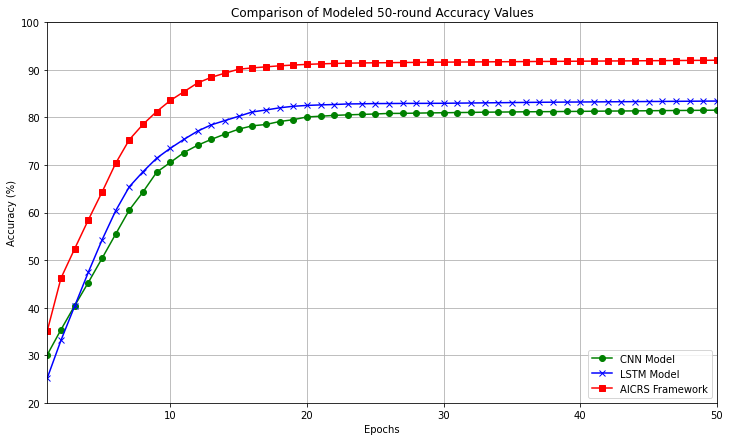

In [21]:
import matplotlib.pyplot as plt
import numpy as np
epochs = np.arange(1, 51)

cnn_accuracy = avg_accuracy2

lstm_accuracy = avg_accuracy3

aicrs_accuracy = avg_accuracy1


plt.figure(figsize=(12, 7))

plt.plot(epochs, cnn_accuracy, label='CNN Model', color='green', marker='o')
plt.plot(epochs, lstm_accuracy, label='LSTM Model', color='blue', marker='x')
plt.plot(epochs, aicrs_accuracy, label='AICRS Framework', color='red', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Modeled 50-round Accuracy Values')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim([20, 100])
plt.xlim([1, 50])
plt.savefig('ACC1.pdf')
plt.show()


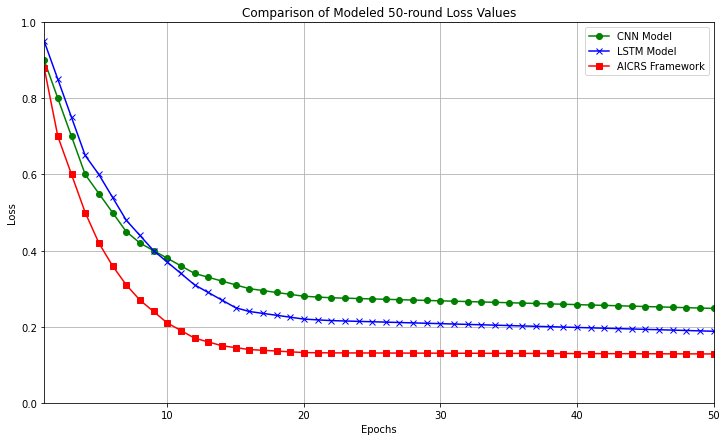

In [22]:
epochs = np.arange(1, 51)


cnn_loss = avg_loss2

lstm_loss = avg_loss3

aicrs_loss = avg_loss1

plt.figure(figsize=(12, 7))

plt.plot(epochs, cnn_loss, label='CNN Model', color='green', marker='o')
plt.plot(epochs, lstm_loss, label='LSTM Model', color='blue', marker='x')
plt.plot(epochs, aicrs_loss, label='AICRS Framework', color='red', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Modeled 50-round Loss Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim([0, 1])
plt.xlim([1, 50])
plt.savefig('Loss.pdf')

plt.show()
